Topographic maps seem to be a fundamental organizing principle of primary sensory cortex. In this lab, we will examine the retinotopic organization of neurons in primary visual cortex based on calcium imaging data.

Here, we have transgenically labeled somatostatin-expressing interneurons with the fluorescent calcium reporter GCaMP6s, and used two photon imaging to record several planes at varying depths in layer 2/3 through a cranial window. Meanwhile, a monitor shows small, isolated patches of drifting black and white gratings in various locations, against a gray screen.

As in many sensory neuroscience experiments, the stimulation computer here delivers known stimuli, precisely timed and randomly interleaved. A TTL pulse from the stimulation computer to the acquisition computer allows us to record the precise timing of the stimuli relative to the recorded neural activity. We start by using an array of inferred "event rates" computed from the raw fluorescence data, an array of stimulus parameters, and a vector of stimulus times. 

In [1]:
import scipy.ndimage.measurements as snm
import numpy as np
# import pyute as ut
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy.io as sio
import pdb
import sklearn.linear_model
import sklearn.cross_validation

%matplotlib inline

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load the (N,T) event rate data, the (K,) frame vector, and the (K,2) stim location array
# our lab's acquisition software is in MATLAB; conveniently, MATLAB files can be read in Python
matfile = sio.loadmat('bootcamp_retinotopy_files.mat',squeeze_me=True)

event_rate = matfile['event_rate'] # the (N,T) event rate data, where N is the number of cells, and T is the number of frames in the experiment

max_projection = matfile['max_projection'] # a max intensity projection of the data, in z and in time
# anterior is left-to-right, medial is bottom-to-top

pix_um = matfile['pix_um'] # width of an imaging pixel, in microns (um)

roi_mask = matfile['roi_mask'] # binary masks of the N segmented ROIs

stim_frame = matfile['stim_frame'] # a (K,2) vector indicating onset and offset of each stimulus

stim_location = matfile['stim_location'] # a (K,2) vector indicating (elevation,azimuth) of each stimulus

depth = matfile['depth'] # a (N,) vector indicating the plane of each ROI. Lower numbers are deeper planes, and the planes are separated by 50 um

sq_deg = matfile['sq_deg'] # the interval at which visual stimuli tile the monitor, in visual degrees

imaging_Hz = matfile['imaging_Hz'] # rate at which a given plane is sampled, in Hz

First, let's look at our pretty picture.

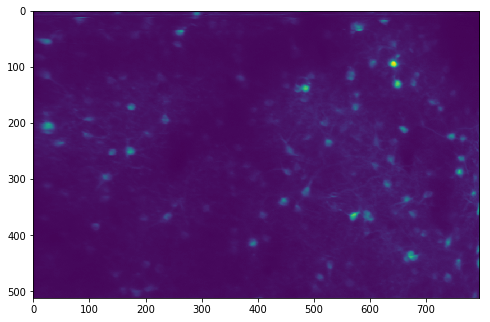

In [3]:
plt.figure(figsize=(8,6))
# plt.subplot(1,3,1)
plt.imshow(max_projection)
# plt.subplot(1,3,2)
# plt.imshow(roi_mask.max(0))
# plt.subplot(1,3,3)


And now, overlaying the segmented ROIs:

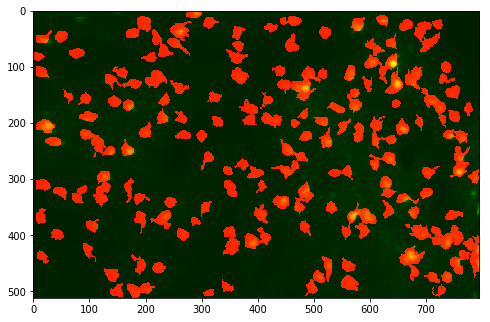

In [4]:
plt.figure(figsize=(8,6))
overlay = np.zeros(max_projection.shape+(3,))
overlay[:,:,0] = roi_mask.max(0)
overlay[:,:,1] = max_projection/max_projection.max()
plt.imshow(overlay)

Now, examining some event rate traces at random:

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'event rate (a.u.)')

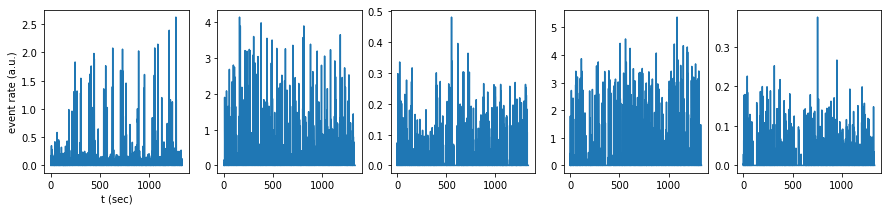

In [6]:
(N,T) = event_rate.shape

plt.figure(figsize=(15,3))
t = np.arange(T)/imaging_Hz
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(t,event_rate[np.random.choice(N)])
plt.subplot(1,5,1)
plt.xlabel('t (sec)')
plt.ylabel('event rate (a.u.)')

Now for some science. We'll first split up our continuous data into a series of sweeps, centered around the time of each stimulus onset. 

In [7]:
nbefore = 2 # we will use a couple frames before each stim onset as a measure of "baseline"
nafter = 0

In [8]:
# write a function to split the (N,T) continuous time series into traces of duration Ttrial to yield an array of size (N,K,Ttrial)
K = stim_frame.shape[0]
stim_duration = np.diff(stim_frame,axis=1)
mean_stim_duration = int(np.round(np.mean(stim_duration)))
Ttrial = mean_stim_duration+nbefore+nafter
trial_event_rate = np.zeros((N,K,Ttrial))
for roi in range(N):
    for trial in range(K):
        trial_event_rate[roi,trial,:] = event_rate[roi,stim_frame[trial,0]-nbefore:stim_frame[trial,0]+mean_stim_duration+nafter]

Then we'll plot what each neuron tends to do on average.

Text(0,0.5,'event rate (a.u.)')

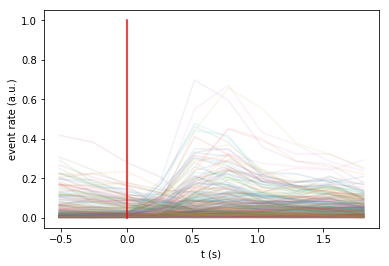

In [9]:
plt.figure()
t = np.arange(-nbefore,mean_stim_duration+nafter)/imaging_Hz
plt.plot(t,trial_event_rate.mean(1).T,alpha=0.1)
plt.plot((0,0),(0,1),c='r')
plt.xlabel('t (s)')
plt.ylabel('event rate (a.u.)')

The majority of neurons seem to become more active after stimulus onset.

Now we'll further split up the data by stimulus condition.

In [10]:
# based on the position (Px,Py) of the stimulus, split the array further into an array of size (N,NPx,NPy,Nreps,Ttrial)
(NPy,NPx) = stim_location.max(0)+1
Nreps = int(K/NPy/NPx)
response = np.zeros((N,NPy,NPx,Nreps,Ttrial))
for roi in range(N):
    for Py in range(NPy):
        for Px in range(NPx):
            look_at = np.logical_and(Py==stim_location[:,0],Px==stim_location[:,1])
            response[roi,Py,Px,:,:] = trial_event_rate[roi,look_at,:]

In [11]:
# average over the 'Nreps' and 'Ttrial' column to yield retinotopic maps
rf = response[:,:,:,:,nbefore:Ttrial-nafter].mean(-1).mean(-1)

Now let's see how the data looks.

In [12]:
# this function shows a series of arrays in rows of 10
def imshow_in_rows(arr,rowlen=10,scale=0.5):
    nrows = np.ceil(arr.shape[0]/rowlen)
    plt.figure(figsize=(scale*rowlen,scale*nrows))
    for k in range(arr.shape[0]):
        plt.subplot(nrows,rowlen,k+1)
        plt.imshow(arr[k])
        plt.axis('off')

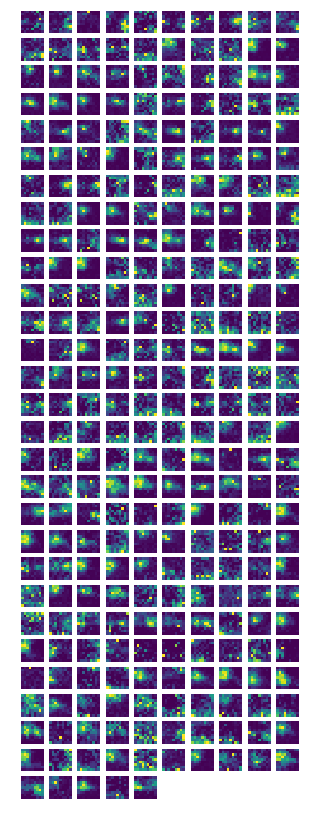

In [13]:
imshow_in_rows(rf)

In [14]:
# visualize the receptive field map by hovering over an ROI

Do the receptive field locations of these somatostatin neurons follow a topographic map? First, we'll compute the ROI centers and receptive field centers using a simple metric, center of mass. Fortunately, Python has lots of libraries for things like this, so we don't have to write much ourselves here.

In [15]:
# write a function to compute center of mass of the receptive field

In [16]:
rf_comy = np.zeros((N,))
rf_comx = np.zeros((N,))
for i in range(N):
    rf_comy[i],rf_comx[i] = snm.center_of_mass(rf[i])
rf_comy = rf_comy*sq_deg
rf_comx = rf_comx*sq_deg

In [17]:
# write a function to compute center of mass of mask

In [18]:
roi_mask_comy = np.zeros((N,))
roi_mask_comx = np.zeros((N,))
for i in range(N):
    roi_mask_comy[i],roi_mask_comx[i] = snm.center_of_mass(roi_mask[i])
roi_mask_comy = roi_mask_comy*pix_um
roi_mask_comx = roi_mask_comx*pix_um

Interestingly, we seem to see both stimulus-driven and stimulus-suppressed somatostatin neurons. We don't expect the center of mass metric to work well for the suppressive RF of the latter group, so we'll ignore them for now.

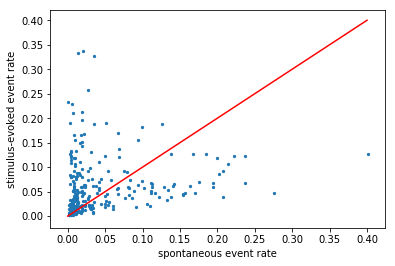

In [19]:
plt.figure()
spont = trial_event_rate[:,:,:2].mean(-1).mean(-1)
evoked = rf.mean(-1).mean(-1)
plt.scatter(spont,evoked,s=5)
plt.xlabel('spontaneous event rate')
plt.ylabel('stimulus-evoked event rate')
plt.plot((0,0.4),(0,0.4),'r')

In [20]:
look_at = evoked>spont

Visually, do these ROIs appear to shift their receptive field centers along a smoothly varying map? We'll color the ROIs according to first their azimuth, then their elevation.

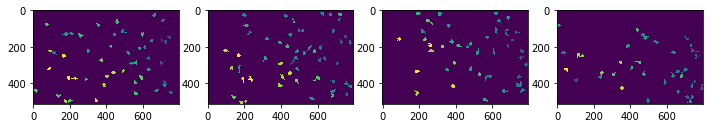

In [21]:
plt.figure(figsize=(12,3))
for k in range(4):
    plt.subplot(1,4,k+1)
    filt = np.logical_and(look_at,depth==k)
    plt.imshow(np.nansum(roi_mask[filt]*rf_comx[filt][:,np.newaxis,np.newaxis],axis=0))

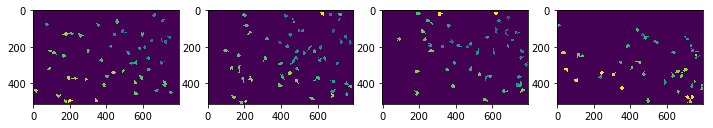

In [22]:
plt.figure(figsize=(12,3))
for k in range(4):
    plt.subplot(1,4,k+1)
    filt = np.logical_and(look_at,depth==k)
    plt.imshow(np.nansum(roi_mask[filt]*rf_comy[filt][:,np.newaxis,np.newaxis],axis=0))

Next, we can plot x-y location on the brain against x-y receptive field location to get a better idea.

Text(0,0.5,'visual elevation (deg)')

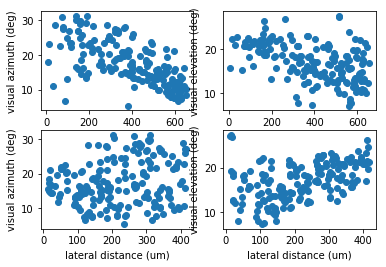

In [23]:
plt.figure()
plt.subplot(2,2,1)
plt.scatter(roi_mask_comx[look_at],rf_comx[look_at])
plt.xlabel('rostral distance (um)')
plt.ylabel('visual azimuth (deg)')

plt.subplot(2,2,2)
plt.scatter(roi_mask_comx[look_at],rf_comy[look_at])
plt.xlabel('rostral distance (um)')
plt.ylabel('visual elevation (deg)')

plt.subplot(2,2,3)
plt.scatter(roi_mask_comy[look_at],rf_comx[look_at])
plt.xlabel('lateral distance (um)')
plt.ylabel('visual azimuth (deg)')

plt.subplot(2,2,4)
plt.scatter(roi_mask_comy[look_at],rf_comy[look_at])
plt.xlabel('lateral distance (um)')
plt.ylabel('visual elevation (deg)')

Now, let's look at whether we can predict receptive field centers from location in the brain. We will use cross-validation, meaning that we will use part of our data to estimate the axes of the retinotopic map, and part of our data to test how accurately these retinotopic axes predict receptive field centers.

In [24]:
regr = sklearn.linear_model.LinearRegression()
X = np.concatenate((roi_mask_comx[look_at,np.newaxis],roi_mask_comy[look_at,np.newaxis]),axis=1)
y = np.concatenate((rf_comx[look_at,np.newaxis],rf_comy[look_at,np.newaxis]),axis=1)
predicted = sklearn.model_selection.cross_val_predict(regr,X,y)
score = sklearn.model_selection.cross_val_score(regr,X,y)

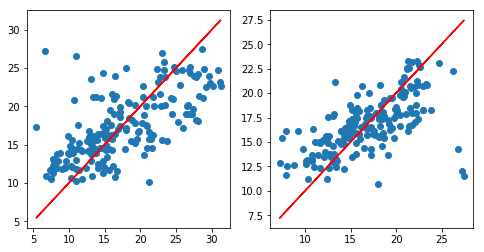

In [25]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(y[:,0],predicted[:,0])
plt.plot(y[:,0],y[:,0],c='r')
plt.subplot(1,2,2)
plt.scatter(y[:,1],predicted[:,1])
plt.plot(y[:,1],y[:,1],c='r')

In [26]:
# Here are the cross-validated R^2 values for each resampling
score

array([ 0.49736077,  0.4401101 ,  0.24740868])